
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      1539
           1       0.99      1.00      0.99     44481

    accuracy                           0.99     46020
   macro avg       0.93      0.86      0.89     46020
weighted avg       0.99      0.99      0.99     46020


Confusion Matrix:

[[ 1120   419]
 [  161 44320]]


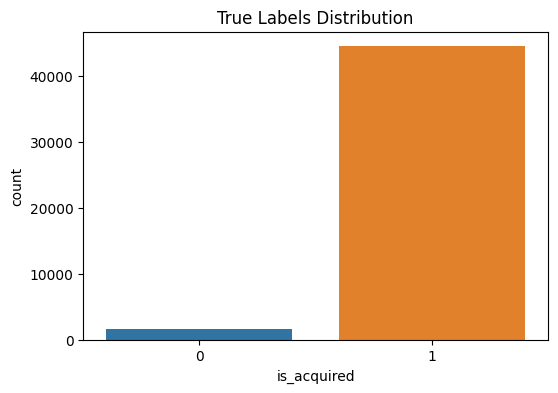

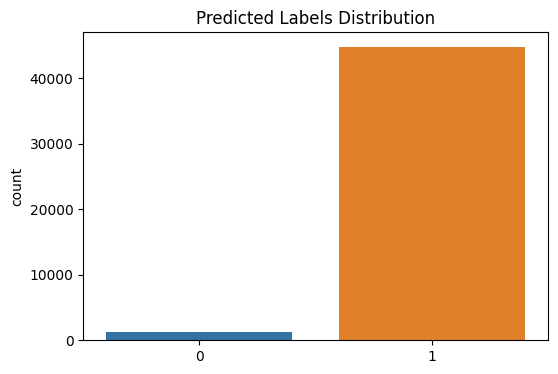

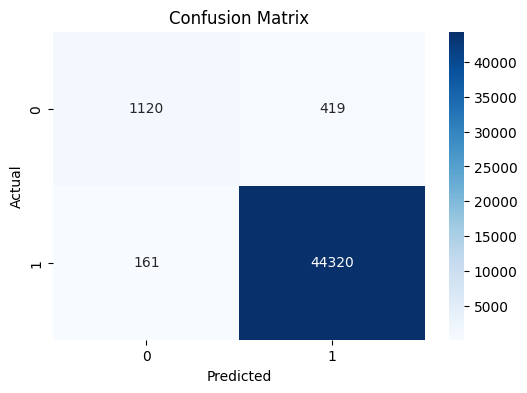

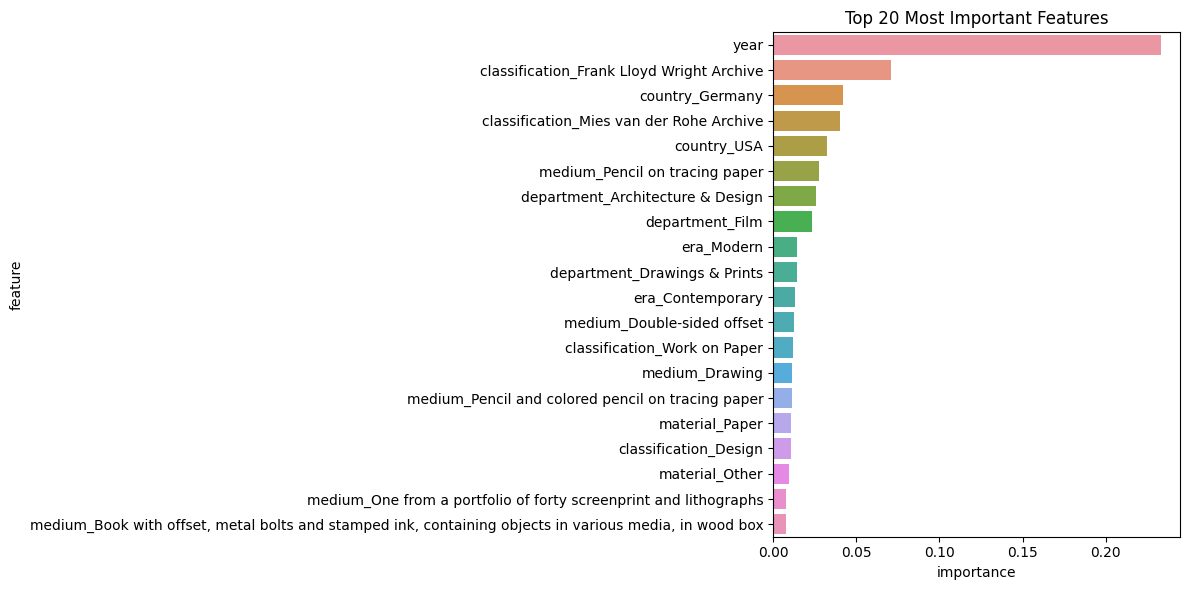


Error type counts:
TP    44320
TN     1120
FP      419
FN      161
Name: error_type, dtype: int64

Gender bias:
error_type                                           FN    FP     TN      TP
gender                                                                      
Female                                              9.0  30.0  288.0  5646.0
Female (transwoman                                  0.0   0.0    0.0    18.0
Female) () (female                                  0.0   0.0    0.0     1.0
Female) () (male                                    0.0   0.0    0.0    25.0
Female) (female                                     0.0   1.0    0.0    69.0
...                                                 ...   ...    ...     ...
Male) (male) (male) (male) (male) (male) (male)...  0.0   0.0    0.0     1.0
Male) (male) (male) (male) (male) (male) (male)...  0.0   0.0    0.0     1.0
Male) (male) (male) (male) (male) (male) (male)...  0.0   0.0    0.0     3.0
Non-binary                              

In [9]:
# 08_model_analysis.ipynb

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Path setup
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# --- Load saved data and model ---
X_test = joblib.load("../outputs/X_test.pkl")
y_test = joblib.load("../outputs/y_test.pkl")
model = joblib.load("../outputs/random_forest_model.pkl")

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Classification report and confusion matrix ---
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# --- Basic plots ---
plt.figure(figsize=(6, 4))
sns.countplot(x=y_test)
plt.title("True Labels Distribution")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred)
plt.title("Predicted Labels Distribution")
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Feature importances ---
rf_model = model.named_steps["classifier"]
preprocessor = model.named_steps["preprocessor"]

numeric_features = ["year"]
categorical_features = ["material", "medium", "classification", "country", "era", "department"]
boolean_features = ["is_known_artist", "is_male", "is_female"]

# Get OHE feature names
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine feature names
all_feature_names = numeric_features + list(cat_feature_names) + boolean_features

# Feature importance DataFrame
importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top 20 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp_df.head(20), x="importance", y="feature")
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()

# Export for review
feat_imp_df.to_csv("../outputs/feature_importances.csv", index=False)

# --- Error analysis ---
errors_df = X_test.copy()
errors_df["true"] = y_test.values
errors_df["pred"] = y_pred
errors_df["error_type"] = errors_df.apply(
    lambda row: "TP" if row.true == 1 and row.pred == 1 else
                "TN" if row.true == 0 and row.pred == 0 else
                "FP" if row.true == 0 and row.pred == 1 else
                "FN",
    axis=1
)

# Count error types
print("\nError type counts:")
print(errors_df["error_type"].value_counts())

# --- Bias analysis ---
# Merge with original info to inspect errors by group
original_df = joblib.load("../outputs/X_test_raw.pkl")
errors_df = errors_df.merge(original_df, left_index=True, right_index=True, suffixes=("", "_raw"))

# Gender bias
gender_bias = errors_df.groupby(["gender", "error_type"]).size().unstack().fillna(0)
print("\nGender bias:")
print(gender_bias)

# Country bias
country_bias = errors_df.groupby(["country", "error_type"]).size().unstack().fillna(0).sort_values(by="FN", ascending=False).head(10)
print("\nCountry bias (top 10 FNs):")
print(country_bias)

# Save errors for exploration
errors_df.to_csv("../outputs/error_analysis.csv", index=False)
